In [3]:
pip install tensorflow==2.9.1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install protobuf==3.20.*


     ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
      --------------------------------------- 20.5/904.0 kB ? eta -:--:--
     - ----------------------------------- 30.7/904.0 kB 435.7 kB/s eta 0:00:03
     -- ---------------------------------- 51.2/904.0 kB 327.7 kB/s eta 0:00:03
     -- ---------------------------------- 51.2/904.0 kB 327.7 kB/s eta 0:00:03
     -- ---------------------------------- 51.2/904.0 kB 327.7 kB/s eta 0:00:03
     -- ---------------------------------- 51.2/904.0 kB 327.7 kB/s eta 0:00:03
     -- ---------------------------------- 51.2/904.0 kB 327.7 kB/s eta 0:00:03
     -- ---------------------------------- 51.2/904.0 kB 327.7 kB/s eta 0:00:03
     -- ---------------------------------- 51.2/904.0 kB 327.7 kB/s eta 0:00:03
     -- ---------------------------------- 51.2/904.0 kB 327.7 kB/s

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\hpomen15\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\google\\~rotobuf\\internal\\_api_implementation.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
# Split data into train, validation, and test sets
def split_data(data_dir):
    class_names = ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Leaf_mold', 'Mosaic_virus',
     'Septoria_leaf_spot', 'Spider_mites', 'Target_spot', 'Yellow_leaf_curl_virus']
    data = []
    labels = []
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            data.append(file_path)
            labels.append(class_name)  # use class_name instead of integer label

    df = pd.DataFrame({'filepaths': data, 'labels': labels})
    train_df, test_df = train_test_split(df, train_size=0.8, stratify=labels, random_state=123)
    valid_df, test_df = train_test_split(test_df, train_size=0.5, stratify=test_df['labels'], random_state=123)
    return train_df, valid_df, test_df



In [3]:
# Create image data generators
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (256, 256)
    channels = 3
    color = 'rgb'

    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        horizontal_flip=True,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        shear_range=0.1,
        fill_mode='nearest'
    )
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    train_gen = tr_gen.flow_from_dataframe(
        train_df, x_col='filepaths', y_col='labels',
        target_size=img_size, class_mode='categorical',
        color_mode=color, shuffle=True, batch_size=batch_size
    )
    valid_gen = ts_gen.flow_from_dataframe(
        valid_df, x_col='filepaths', y_col='labels',
        target_size=img_size, class_mode='categorical',
        color_mode=color, shuffle=True, batch_size=batch_size
    )
    test_gen = ts_gen.flow_from_dataframe(
        test_df, x_col='filepaths', y_col='labels',
        target_size=img_size, class_mode='categorical',
        color_mode=color, shuffle=False, batch_size=batch_size
    )
    return train_gen, valid_gen, test_gen

In [4]:
# Display images from generator
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize=(20, 20))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()


In [5]:
# Define MyCallback class
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch

        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_train_begin(self, logs=None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds'
        print(msg)
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count += 1
                    self.count = 0
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count += 1

        else:
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    self.stop_count += 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                else:
                    self.count += 1

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            msg = f'training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f'training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

In [6]:

# Plot training history
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [7]:

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


Found 22126 validated image filenames belonging to 10 classes.
Found 2766 validated image filenames belonging to 10 classes.
Found 2766 validated image filenames belonging to 10 classes.


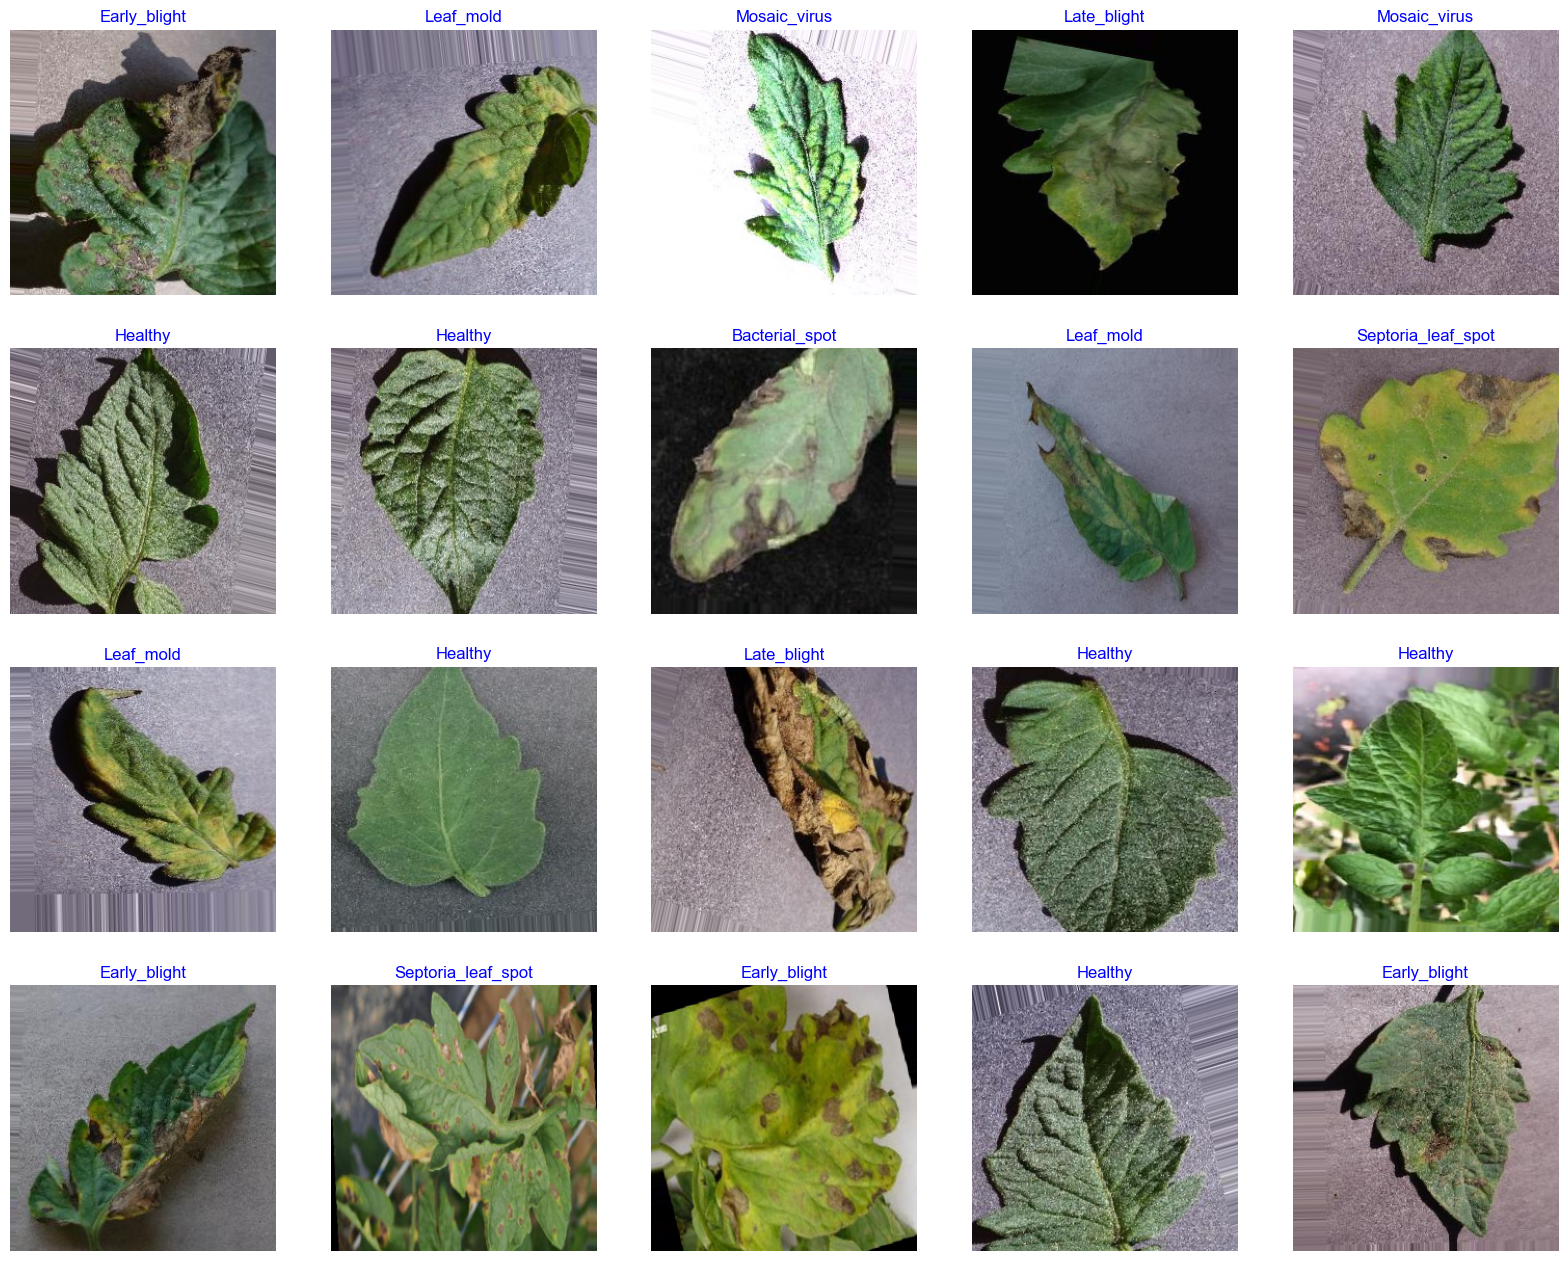

In [14]:

# Start reading dataset
data_dir = 'E:/farid/merge'
train_df, valid_df, test_df = split_data(data_dir)
batch_size = 20
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)
show_images(train_gen)


In [15]:
# Create Model Structure
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top= False, 
    weights= "imagenet", 
    input_shape= img_shape, 
    pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 11,185,721
Trainable params: 11,095,346
Non-trainable params: 90,375
_____________________________________

In [16]:
epochs = 10
patience = 3
stop_patience = 5
threshold = 0.9
factor = 0.5
ask_epoch = 5
batches = int(np.ceil(len(train_gen.labels) / batch_size))
callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold, factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]


In [17]:
history = model.fit(train_gen, epochs=epochs, verbose=0, callbacks=callbacks, validation_data=valid_gen)

Do you want model asks you to halt the training [y/n] ?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     4.341   82.487   1.52867  94.071   0.00100  0.00100  accuracy     0.00   4931.85  
 2 /10     0.894   93.424   0.49321  95.806   0.00100  0.00100  val_loss    67.74   5072.75  
 3 /10     0.441   96.014   0.35516  96.421   0.00100  0.00100  val_loss    27.99   5367.92  
 4 /10     0.346   96.954   0.27310  97.903   0.00100  0.00100  val_loss    23.10   5096.99  
 5 /10     0.285   97.813   0.26225  97.325   0.00100  0.00100  val_loss     3.97   5066.31  
enter H to halt training or an integer for number of epochs to run then ask again
training has been halted at epoch 5 due to user input
training elapsed time was 7.0 hours,  5.0 minutes, 58.56 seconds


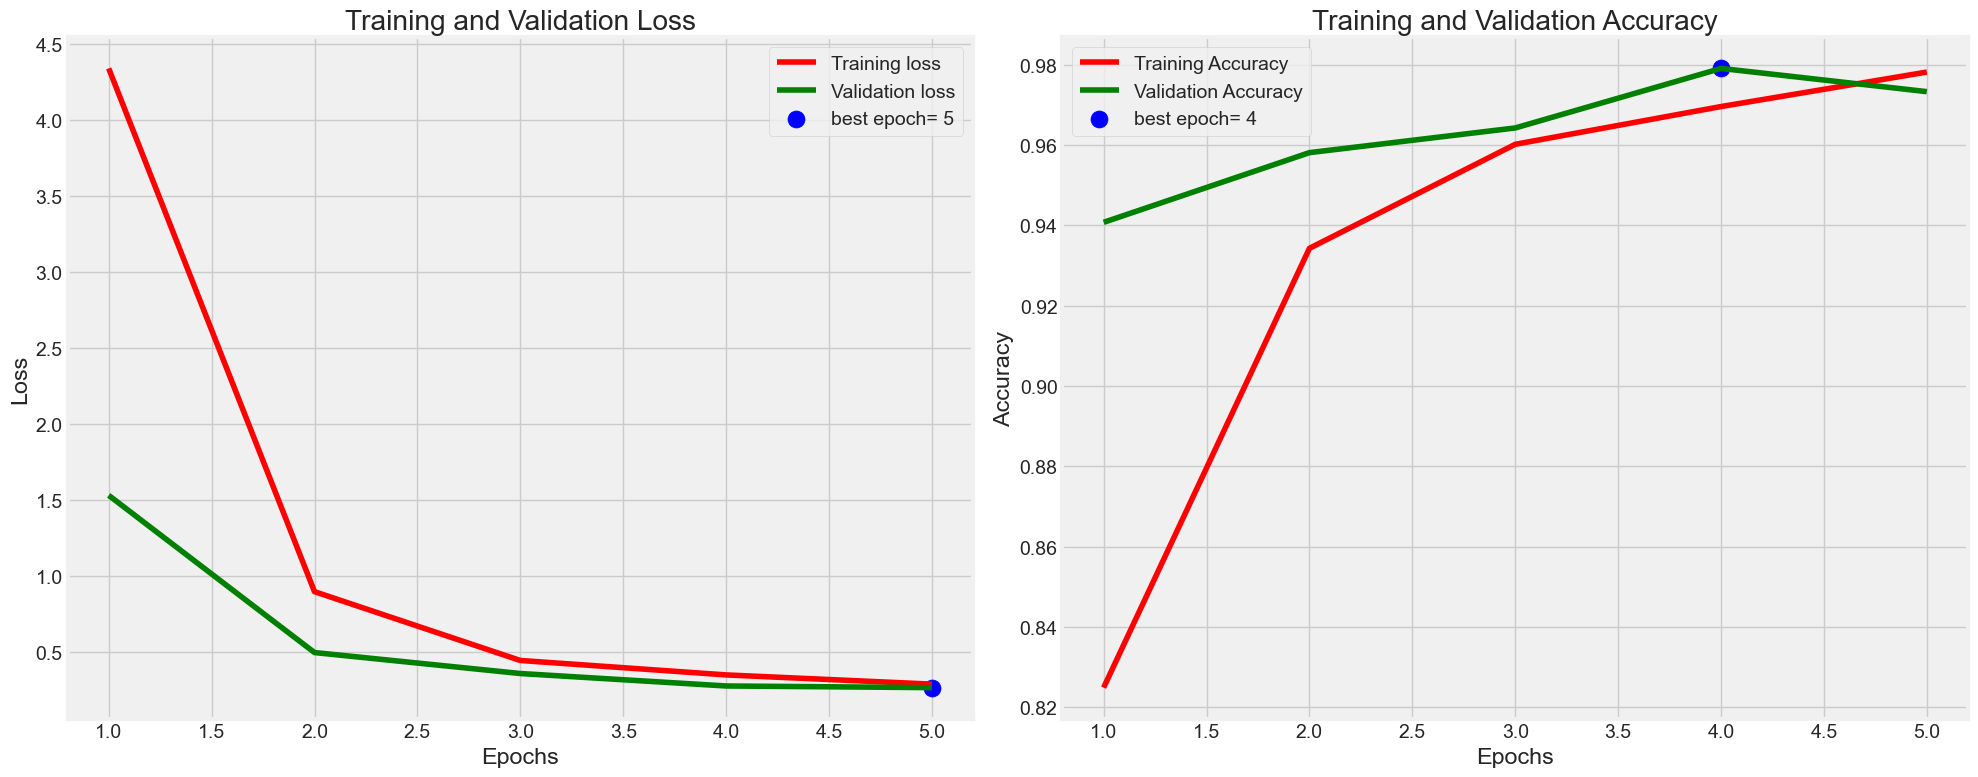

In [18]:
plot_training(history)

In [19]:

# Evaluate model
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


139/139 [==============================] - 132s 951ms/step - loss: 0.2506 - accuracy: 0.9794
Train Loss:  0.2034662365913391
Train Accuracy:  0.9923619031906128
--------------------
Validation Loss:  0.2622544765472412
Validation Accuracy:  0.9732465744018555
--------------------
Test Loss:  0.25064417719841003
Test Accuracy:  0.9793926477432251


In [20]:

# Get predictions
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)


139/139 [==============================] - 137s 963ms/step
[0 2 8 ... 6 8 0]


Confusion Matrix, Without Normalization
[[299   2   0   0   0   0   3   0   0   0]
 [  1 275   0   2   0   0   0   0   0   0]
 [  0   1 317   0   1   0   0   0   7   3]
 [  0   0   0 333   1   0   0   0   0   0]
 [  0   0   1   0 312   0   0   0   0   0]
 [  0   0   0   0   0 261   0   0   0   0]
 [  1   2   2   0   1   0 283   0  21   0]
 [  0   0   4   0   0   0   0 191   3   0]
 [  0   0   0   1   0   0   0   0 206   0]
 [  0   0   0   0   0   0   0   0   0 232]]
                        precision    recall  f1-score   support

        Bacterial_spot       0.99      0.98      0.99       304
          Early_blight       0.98      0.99      0.99       278
               Healthy       0.98      0.96      0.97       329
           Late_blight       0.99      1.00      0.99       334
             Leaf_mold       0.99      1.00      0.99       313
          Mosaic_virus       1.00      1.00      1.00       261
    Septoria_leaf_spot       0.99      0.91      0.95       310
          Spider

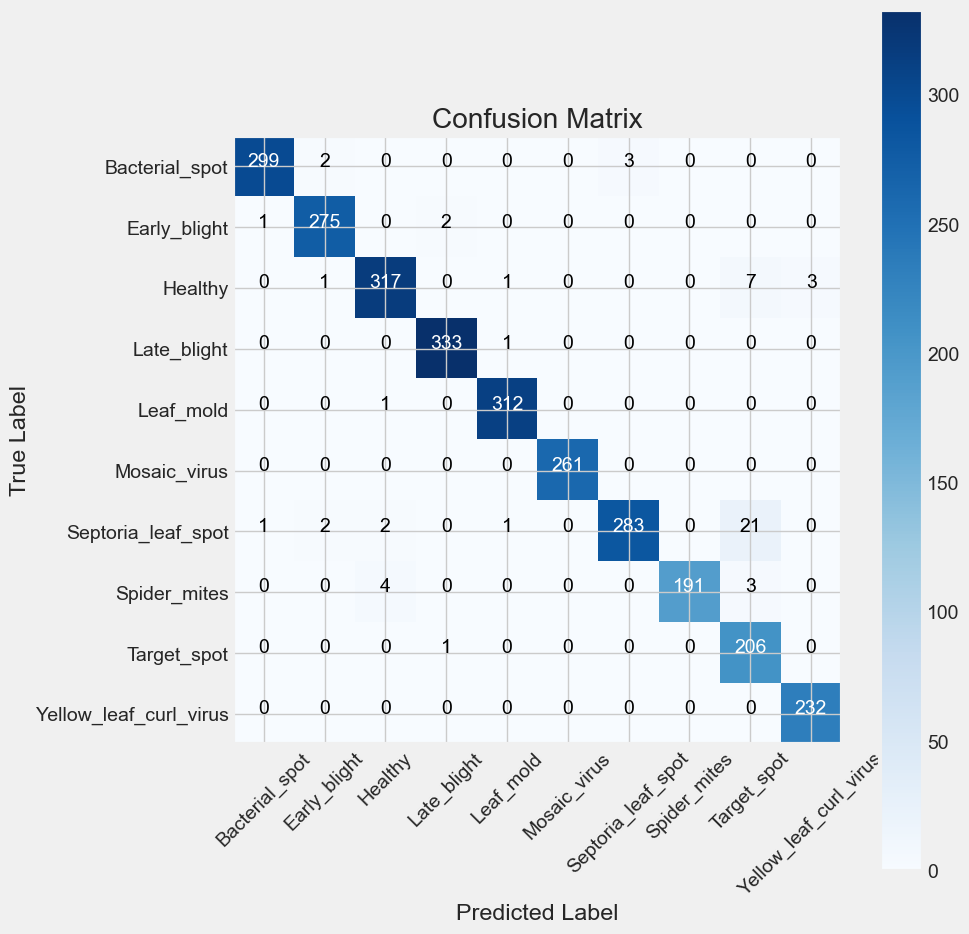

In [21]:

# Confusion matrix and classification report
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm, classes, title='Confusion Matrix')
print(classification_report(test_gen.classes, y_pred, target_names=classes))


In [22]:

# Save model and weights
model_name = model.input_names[0][:-6]
subject = 'TomKit'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.h5'
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = f'{model_name}-{subject}-weights.h5'
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetb3-TomKit-97.94.h5
weights were saved as efficientnetb3-TomKit-weights.h5


In [23]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as TomKit-class_dict.csv
